# <center>CITS5508 Lab sheet 2</center>

**Name:** Alastair Mory<br>
**Student number:** 21120848<br>

This lab explores a dataset from UC Irvine ([available here](http://archive.ics.uci.edu/ml/datasets/Forest+type+mapping#)) using some techniques learned in this unit so far. 
The dataset records different forrest types and their their spectral characteristics at visible-to-near infrared wavelengths.

Two classification techniques will be used to attempt to predict forrest types: stochastic gradient descent with binary one-vs-all classification and logistic multiclass classification.

<br>

<b>Contents</b><br>
[1. The Data](#1.-The-data)<br>
[2. Reorganise data](#2.-Reorganise-data)<br>
[3. Check class balance](#3.-Check-class-balance)<br>
[4. Data normalisation](#4.-Data-normalisation)<br>
[5. Stochastic Gradient Descent](#5.-Stochastic-Gradient-Descent)<br>
[6. Logistic regression](#6.-Logistic-Regression)<br>
[7. Conclusion](#7.-Conclusion)<br>

In [1]:
import typing
from typing import Any, Dict, List, Tuple  # Types make method defs more useful.
import warnings  # Used to clearup some sklearn output.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier

# Constants
CLASS_LABELS = ['s', 'h', 'd', 'o']
DATA_LABELS = ["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9"]

# Additional type notation
Array = typing.Union[List, np.array, pd.DataFrame]  # np "array_like" type


 
 # 1. The data

The data used for this lab comes from the paper [Using geographically-weighted variables for image classification](http://www.cr.chiba-u.jp/~tateishi-lab/pdf/2011/Using%20geographically%202011.pdf) (Johnson, Tateishi & Xie 2012)

The attributes (columns) of interest are:<br>
<b>Class:</b> 's' ('Sugi' forest), 'h' ('Hinoki' forest), 'd' ('Mixed deciduous' forest), 'o' ('Other' non-forest land)<br>
<b>b1 - b9:</b> ASTER image bands containing spectral information in the green, red, and near infrared wavelengths for three dates (Sept. 26, 2010; March 19, 2011; May 08, 2011.)<br>

The data was collected from various points within these satellite images:
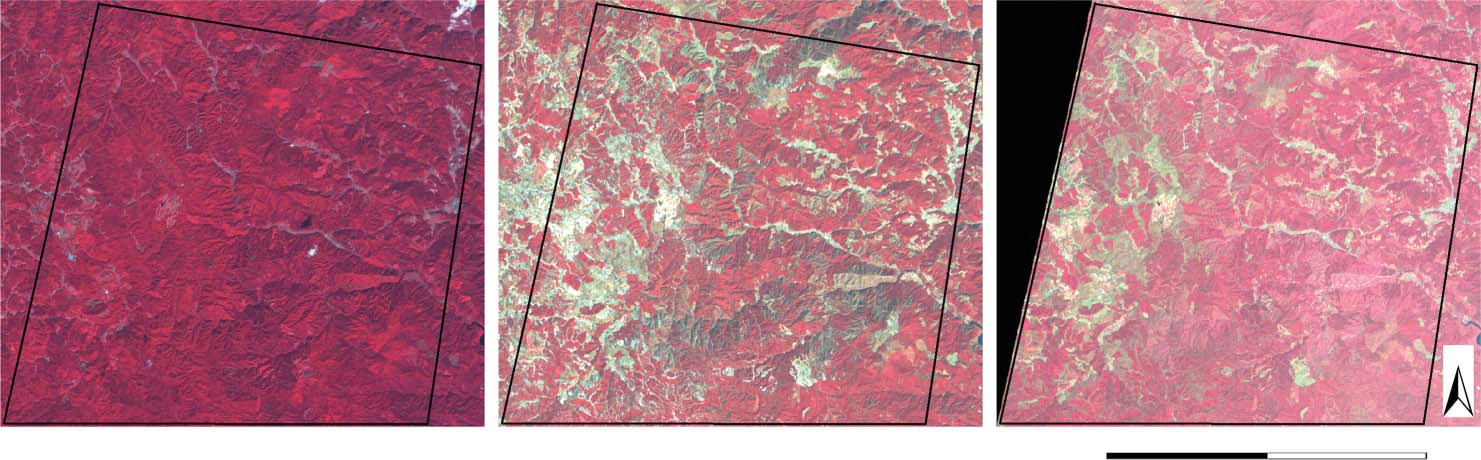


<b>Tasks:</b><br>
1.1 Read in the contents of both csv files.<br>
1.2 Inspect what the columns are by displaying the first few lines of the file.<br>
1.3 Use appropriate functions to display (visualize) the different features (or attributes / columns).<br>
1.4 Display some plots for visualizing the data.<br>
1.5 Describe what you see.<br>

In [2]:
# 1.1
training_orig = pd.read_csv("training.csv")
testing_orig = pd.read_csv("testing.csv")

# 1.2
print("Data Columns:\n", *training_orig.columns)
# OR
training_orig.head()

Data Columns:
 class b1 b2 b3 b4 b5 b6 b7 b8 b9 pred_minus_obs_H_b1 pred_minus_obs_H_b2 pred_minus_obs_H_b3 pred_minus_obs_H_b4 pred_minus_obs_H_b5 pred_minus_obs_H_b6 pred_minus_obs_H_b7 pred_minus_obs_H_b8 pred_minus_obs_H_b9 pred_minus_obs_S_b1 pred_minus_obs_S_b2 pred_minus_obs_S_b3 pred_minus_obs_S_b4 pred_minus_obs_S_b5 pred_minus_obs_S_b6 pred_minus_obs_S_b7 pred_minus_obs_S_b8 pred_minus_obs_S_b9


,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,39,36,57,91,59,101,93,27,60,...,-2.36,-18.41,-1.88,-6.43,-21.03,-1.60,-6.18,-22.50,-5.20,-7.86
1,h,84,30,57,112,51,98,92,26,62,...,-2.26,-16.27,-1.95,-6.25,-18.79,-1.99,-6.18,-23.41,-8.87,-10.83
2,s,53,25,49,99,51,93,84,26,58,...,-1.46,-15.92,-1.79,-4.64,-17.73,-0.48,-4.69,-19.97,-4.10,-7.07
3,s,59,26,49,103,47,92,82,25,56,...,2.68,-13.77,-2.53,-6.34,-22.03,-2.34,-6.60,-27.10,-7.99,-10.81
4,d,57,49,66,103,64,106,114,28,59,...,-2.94,-21.74,-1.64,-4.62,-23.74,-0.85,-5.50,-22.83,-2.74,-5.84


In [213]:
# 1.3
training_orig.describe()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,pred_minus_obs_H_b1,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,...,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,62.949495,41.020202,63.676768,101.409091,58.732323,100.651515,90.601010,28.691919,61.116162,50.818889,...,-5.594141,-20.037576,-1.007121,-4.355657,-20.996919,-0.973737,-4.597626,-18.840000,-1.570808,-4.155859
std,12.779563,17.832543,17.314545,14.804627,12.392648,11.190314,15.588861,8.977752,9.787158,12.842321,...,9.769193,4.948562,1.783671,2.352311,6.490763,0.702619,1.736712,5.251095,1.807792,1.982423
min,34.000000,25.000000,47.000000,54.000000,44.000000,84.000000,54.000000,21.000000,50.000000,7.660000,...,-53.530000,-32.950000,-8.800000,-11.210000,-40.370000,-3.270000,-8.730000,-34.140000,-8.870000,-10.830000
25%,54.000000,28.000000,52.000000,92.250000,49.000000,92.000000,80.000000,24.000000,55.000000,40.667500,...,-6.627500,-23.325000,-1.860000,-5.790000,-24.090000,-1.290000,-5.747500,-22.237500,-2.370000,-5.122500
50%,60.000000,31.500000,57.000000,99.500000,55.000000,98.000000,91.000000,25.000000,58.000000,53.030000,...,-2.255000,-20.020000,-0.970000,-4.350000,-20.465000,-0.945000,-4.540000,-19.200000,-1.420000,-4.125000
75%,70.750000,50.750000,69.000000,111.750000,65.000000,107.000000,101.000000,27.000000,63.000000,59.920000,...,0.247500,-17.787500,-0.042500,-2.882500,-17.955000,-0.642500,-3.617500,-16.227500,-0.655000,-3.105000
max,105.000000,160.000000,196.000000,172.000000,98.000000,136.000000,139.000000,82.000000,109.000000,83.320000,...,5.740000,5.130000,12.460000,7.370000,1.880000,3.440000,3.940000,3.670000,8.840000,7.790000


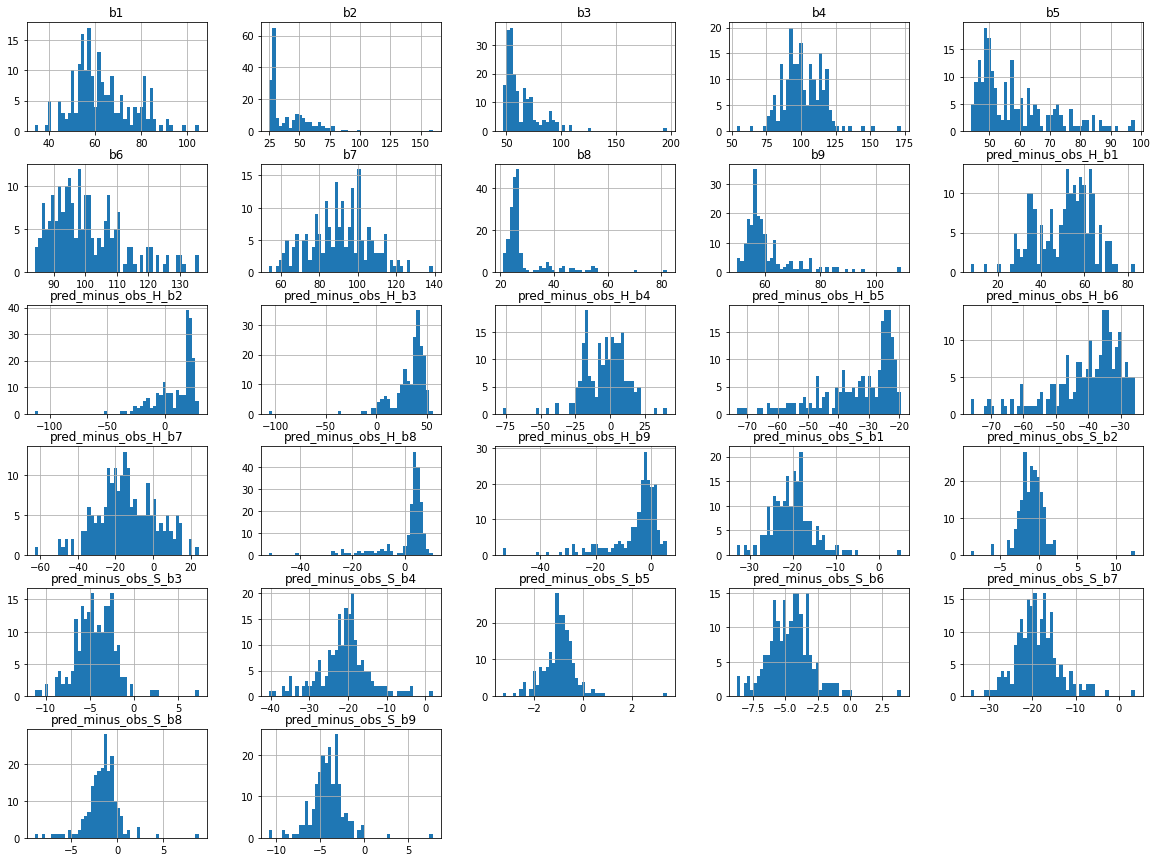

In [214]:
# 1.4
%matplotlib inline
# Ignore matplotlib warning about pandas df.hist() using deprecated attributes
warnings.filterwarnings("ignore")
training_orig.hist(bins=50, figsize=(20,15))
plt.show()

The columns of interest (b1-b9) are roughly either normally distributed (b1, b4, b7) or distributed with a strong positive skewness (b2, b3, b5, b8, b9), b6 falls inbetween these two types. It's unclear what each individual column represents so there is little we can infer from this, however as mentioned above they are collectively the green, red and near-infrared values of points taken from satellite imagery from three seperate dates.

# 2. Reorganise data

<b>Tasks:</b><br>
2.1 Remove all the columns whose names begin with pred_minus_obs.<br>
2.2 Extract class labels from the first column of both data sets.<br>

In [215]:
# 2.2 Extract class labels
training_labels = training_orig["class"]
testing_labels = testing_orig["class"]

# 2.1 Remove columns with 'pred_minus_obs' prefix and class column.
columns_to_drop = [x for x in training_orig.columns if x not in DATA_LABELS]

training = training_orig.drop(columns=columns_to_drop)
testing = testing_orig.drop(columns=columns_to_drop)

# Check we have correct columns
for col in training.columns:
    assert col in DATA_LABELS
for col in testing.columns:
    assert col in DATA_LABELS
for col in DATA_LABELS:
    assert col in training.columns
    assert col in testing.columns

# Show columns
training.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,39,36,57,91,59,101,93,27,60
1,84,30,57,112,51,98,92,26,62
2,53,25,49,99,51,93,84,26,58
3,59,26,49,103,47,92,82,25,56
4,57,49,66,103,64,106,114,28,59


# 3. Check class balance

<b>Tasks:</b><br>
3.1 Count the number of instance for each class label.<br>
3.2 Do you have an imbalanced training set?<br>

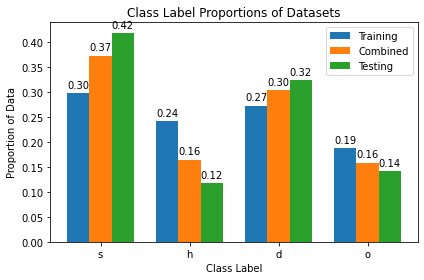

In [216]:
# 3.1
def count_labels(data: List[str]) -> List[int]:
    """Counts number of instances of each class label in data."""
    counts = []
    for label in CLASS_LABELS:
        counts.append(sum([x == label for x in data]))
    return counts


def label_proportions(data: List[str]) -> List[float]:
    """Get a list of what proportion each class is of total data."""
    counts = count_labels(data)
    total = sum(counts)
    proportions = [counts[i] / total for i in range(len(counts))]
    return proportions

training_proportions = label_proportions(training_labels)
testing_proportions = label_proportions(testing_labels)
combined_proportions = label_proportions(pd.concat((training_labels, testing_labels)))

labels = CLASS_LABELS
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, training_proportions, width, label='Training')
rects2 = ax.bar(x, combined_proportions, width, label='Combined')
rects3 = ax.bar(x +  width, testing_proportions, width, label='Testing')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Class Label')
ax.set_ylabel('Proportion of Data')
ax.set_title('Class Label Proportions of Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:3.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

<b>\# 3.2</b> Is the training set imbalanced?<br>
The classes of the training dataset have proportions between 0.19 and 0.3, which is close to the expected 0.25 for a dataset with four classes, so it is relatively balanced.

## 4. Data normalisation

<b>Tasks:</b><br>
4.1 Select an appropriate data normalisation method.<br>
4.2 Normalise the data, ensuring the method is the same for both datasets.<br>

In [217]:
# 4.1 & 4.2 Scale feature values
def scale(training: Array, testing: Array) -> Tuple[Array, Array]:
    scaler = StandardScaler().fit(training)
    training_scaled = scaler.transform(training)
    testing_scaled = scaler.transform(testing)
    return (training_scaled, testing_scaled)

training_scaled, testing_scaled = scale(training, testing)

## 5. Stochastic Gradient Descent

[Scikit-learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor)

<b>Tasks:</b><br>
5.1 Use the stochastic gradient descent classifier to perform one-versus-all
    binary classification on the 4 class labels.<br>
5.2 Show the confusion matrix on the test set.<br>
5.3 Try experimenting with some hyperparameters to see if you can improve the
    performance of the classification.<br>

In [218]:
def print_confusion_matrix(predictions: Array, actual: Array, label: str):
    """Print a confusion matrix with labeled rows and columns."""
    confusion_matrix = sklearn.metrics.confusion_matrix(actual, predictions)
    tn, fp, fn, tp = confusion_matrix.ravel()
    print(f"Class {label} confusion matrix:")
    data = np.array([[tp, tn], [fp, fn]])
    row_titles=("Correct", "Incorrect")
    column_titles=(f"is {label}", f"not {label}")
    data_table = pd.DataFrame(data, row_titles, column_titles)
    print(data_table)

# Create classifier
clf = SGDClassifier(loss="log",
                    penalty="l2",
                    max_iter=500,
                    tol=0.01)

print("Stochastic gradient descent (SGD) binary classification:")
sgd_results: Dict[str, Dict[str, List[bool]]] = {}
for label in CLASS_LABELS:
    # Classification fit & predict parameters
    x_train = training_scaled
    y_train = [x is label for x in training_labels]
    x_test = testing_scaled
    # Get true and predicted labels
    y_true = [x is label for x in testing_labels]
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    # Store results
    sgd_results[label] = {}
    sgd_results[label]["y_true"] = y_true
    sgd_results[label]["y_pred"] = y_pred

    print("")
    print_confusion_matrix(y_pred, y_true, label)

# Calculate accuracy:
total = len(testing_labels) * len(CLASS_LABELS)
correct = 0
for label in CLASS_LABELS:
    for i in range(len(testing_labels)):
        if sgd_results[label]["y_true"][i] == sgd_results[label]["y_pred"][i]:
            correct += 1
print(f"\n\nAccuracy: {correct/total*100}%")
            

Stochastic gradient descent (SGD) binary classification:

Class s confusion matrix:
           is s  not s
Correct     104    171
Incorrect    18     32

Class h confusion matrix:
           is h  not h
Correct      32    279
Incorrect     8      6

Class d confusion matrix:
           is d  not d
Correct      67    211
Incorrect     9     38

Class o confusion matrix:
           is o  not o
Correct      33    272
Incorrect     7     13


Accuracy: 89.92307692307693%


## 6. Logistic Regression

[Scikit-learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)


<b>Tasks</b><br>
6.1 Use LogisticRegressionCV to perform multiclass classification on the 4
    classes.<br>
6.2 Show the confusion matrix on the test set.<br>
6.3 Try experimenting with some hyperparameters to see if you can improve the
    performance of the classification.<br>

In [219]:
clf = LogisticRegressionCV(max_iter=500)

x_train = training_scaled
y_train = training_labels
x_test = testing_scaled
y_true = testing_labels

y_pred = clf.fit(x_train, y_train).predict(x_test)

cm = sklearn.metrics.confusion_matrix(y_pred, y_true)
print(cm)

total = sum(sum(cm))
correct = cm[0][0] + cm[1][1] + cm[2][2] + cm[3][3]
print(f"Accuracy: {correct/total*100}%")

[[ 82   0   9   2]
 [  3  29   0  13]
 [  9   0  33   0]
 [ 11   9   4 121]]
Accuracy: 81.53846153846153%


# 7. Conclusion

Although the SGD binary classifier can make single class predictions with a higher accuracy (~90%) than the logistic regressor multiclass classifier (83%) little can be aid of this difference because the tasks are fundamentally different.